
# **Highway to Hell (Or Heaven)**
---

**By Ashvin Anilkumar**              

## 1. Introduction

In a fiercely competitive marketplace, two manufacturing plants, **ShoeCo** and **BootCo**, race to deliver the same product to customers but utilize different production technologies, leading to distinct cost structures and defect rates. These plants feed a shared logistics network comprising ports, carriers, warehouses, and final retail shops. The market is competitive, enforcing a uniform selling price regardless of origin.

The core challenge is to determine the optimal production quantities at each plant and the subsequent flow of goods through the network to **maximize total expected profit**. This decision must be robust against uncertain market demand, which is modeled using a discrete set of scenarios (e.g., Low, Medium, High demand).
|Scenario ($\omega$) |Probability ($\pi_\omega$) |Demand ($D_{s\omega}$) |
|-------------|-----------------|---------------|
|Low Demand  |30%  | 0.7$D_{s\omega}$ |  
|Medium Demand  |50%  |$D_{s\omega}$|
|High Demand  |20%  |1.3$D_{s\omega}$|


<img height=400 align="center" src="https://github.com/ashvin-a/Final-Project-524/blob/main/docs/Logistic-graph.svg?raw=1"/>







This is a simple diagram of our optimisation problem. We will start with this and later on build the actual figure of the problem.
The problem is formulated as a Two-Stage Stochastic Mixed-Integer Linear Program (MILP):

- Stage 1 (Strategic/Tactical): Production quantities, initial shipping from plants to ports, and carrier selection must be decided before demand is known.

- Stage 2 (Operational/Recourse): Once demand is realized (per scenario), inventory allocation, final distribution to shops, shortage penalties, and defect handling are determined.

## 2. Approach




We will first analyse the data from the excel sheet and then we will try to make a model which will solve for the optimal path and quantity to be produced for both the plants. Let's start by analysing the data that is given.


In [5]:
!pip install gamspy
!gamspy install license 2a571695-fbd3-4aa6-9587-b3d6083d1be8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.0/223.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 54.7 MB/s eta 0:00:00


In [8]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gamspy as gp
import itertools

np.random.seed(42)

In [9]:

sheet_names = ["OrderList",
               "FreightRates",
               "WhCosts",
               "WhCapacities",
               "ProductsPerPlant",
               "PlantPorts",
               "VmiCustomers",]

df = pd.read_excel("data.xlsx", sheet_name=sheet_names)

# Data Analysis
for index, dataframe in df.items():
  print(f"\n\n\nTable name: {index}\n Dataframe Summary : {dataframe.columns}\n")
  for column in dataframe.columns:
    if column not in ["Order ID", "Product ID", "minimum cost", "max_wgh_qty", "minm_wgh_qty"]:
      # print(f"Column name : {column}\n ")
      print(f"Column name : {column}\n Unique Entries :{dataframe[column].unique()}")




Table name: OrderList
 Dataframe Summary : Index(['Order ID', 'Order Date', 'Origin Port', 'Carrier', 'TPT',
       'Service Level', 'Ship ahead day count', 'Ship Late Day count',
       'Customer', 'Product ID', 'Plant Code', 'Destination Port',
       'Unit quantity', 'Weight'],
      dtype='object')

Column name : Order Date
 Unique Entries :<DatetimeArray>
['2013-05-26 00:00:00']
Length: 1, dtype: datetime64[ns]
Column name : Origin Port
 Unique Entries :['PORT09' 'PORT04' 'PORT05']
Column name : Carrier
 Unique Entries :['V44_3' 'V444_0' 'V444_1']
Column name : TPT
 Unique Entries :[1 4 0 2 3]
Column name : Service Level
 Unique Entries :['CRF' 'DTP' 'DTD']
Column name : Ship ahead day count
 Unique Entries :[3 0 5 6 1]
Column name : Ship Late Day count
 Unique Entries :[0 6 1 3]
Column name : Customer
 Unique Entries :['V55555_53' 'V555555555555555_29' 'V5555555_30' 'V55555_2'
 'V555555555555_31' 'V55555555_32' 'V5555555_12' 'V55555_4' 'V555555_6'
 'V5555555555_1' 'V5555_33' '

#### 2.1 Data Analysis
As we can observe, the excel sheet consists of 7 sheets. Here is the description on what each sheets tells us about:

- OrderList: Contains historical records of how the orders were routed and demand satisfied.
- FreightRates: Describes all available couriers, the weight gaps for each individual lane and rates associated.
- WhCosts: Specifies the cost associated in storing the products in given warehouse measured in dollars per unit.
- WhCapacities: Lists warehouse capacities measured in number of orders per day and the WhCosts specifies the cost associated in storing the products in given warehouse measured in dollars per unit.
- ProductsPerPlant: Lists all supported warehouse-product combinations.
- PlantPorts:  Describes the allowed links between the warehouses and shipping ports in real world.
- VmiCustomers: Lists all special cases, where warehouse is only allowed to support specific customer, while any other non-listed warehouse can supply any customer.

For a better visualization and understanding of the data, lets plot a node graph of the scenario.

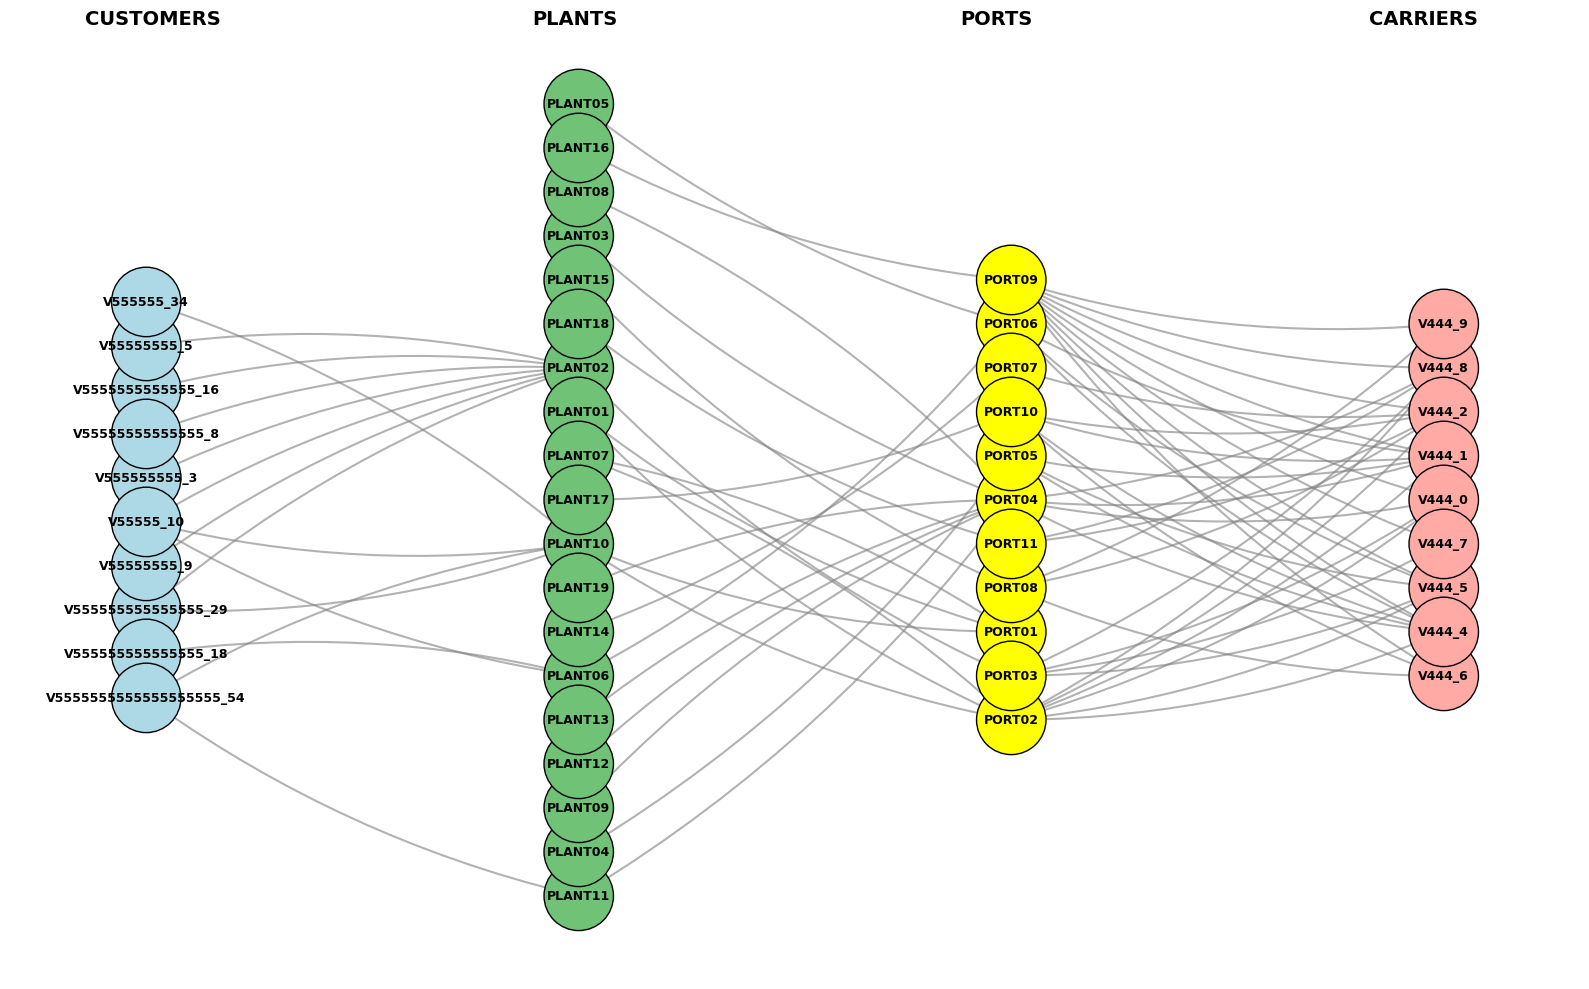

In [10]:
df_orderlist = df['OrderList']
df_freight = df['FreightRates']
df_wh_cost = df['WhCosts']
df_wh_capacity = df['WhCapacities']
df_prod_plant = df['ProductsPerPlant']
df_plant_ports = df['PlantPorts']
df_vmi_cust = df['VmiCustomers']

G = nx.Graph()

layer_map = {
    'Customer': 0,
    'Plant': 1,
    'Port': 2,
    'Carrier': 3
}

# Helper to add nodes with the correct 'layer' attribute
def add_layered_node(graph, node_name, category):
    if node_name not in graph:
        graph.add_node(node_name, layer=layer_map[category], category=category)

# A. Connect Plants (Layer 1) to Customers (Layer 0)
for _, row in df_vmi_cust.iterrows():
    plant = row['Plant Code']
    cust = row['Customers']

    add_layered_node(G, plant, 'Plant')
    add_layered_node(G, cust, 'Customer')
    G.add_edge(plant, cust)

# B. Connect Plants (Layer 1) to Ports (Layer 2)
for _, row in df_plant_ports.iterrows():
    plant = row['Plant Code']
    port = row['Port']

    add_layered_node(G, plant, 'Plant')
    add_layered_node(G, port, 'Port')
    G.add_edge(plant, port)

# C. Connect Ports (Layer 2) to Carriers (Layer 3)
# Note: Since Carriers connect Port-to-Port, visually we place them
# in the next layer to show the "hop".
for _, row in df_freight.iterrows():
    carrier = row['Carrier']
    origin = row['orig_port_cd']
    dest = row['dest_port_cd']

    # Ensure all exist
    add_layered_node(G, origin, 'Port')
    add_layered_node(G, dest, 'Port')
    add_layered_node(G, carrier, 'Carrier')

    G.add_edge(origin, carrier)
    G.add_edge(carrier, dest)

# 3. VISUALIZE WITH MULTIPARTITE LAYOUT
plt.figure(figsize=(16, 10))

# It looks at the 'layer' attribute we set earlier to align nodes vertically
pos = nx.multipartite_layout(G, subset_key="layer")

# Define distinct colors
color_map = []
node_colors = {
    'Customer': '#ADD8E6',
    'Plant':    '#6FC276',
    'Port':     '#FFFF00',
    'Carrier':  '#ffaaa5'
}

for node in G:
    cat = G.nodes[node]['category']
    color_map.append(node_colors.get(cat, 'grey'))

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=2500, edgecolors='black')

# Draw Labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Draw Edges (Curved lines often look neater in layered graphs)
# connectionstyle="arc3,rad=0.1" creates a slight curve
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.6,
                       connectionstyle="arc3,rad=0.1", arrows=True)

# Add Layer Headers (Manual Text to label the columns)
plt.text(-0.17, 1.2, "CUSTOMERS", fontsize=14, fontweight='bold', )
plt.text(-0.055, 1.2, "PLANTS", fontsize=14, fontweight='bold', )
plt.text(0.055, 1.2, "PORTS", fontsize=14, fontweight='bold',)
plt.text(0.16, 1.2, "CARRIERS", fontsize=14, fontweight='bold', )

plt.axis('off')
plt.tight_layout()
plt.show()


We can see that there is no separate entity for plants. What they mean by the "plants" in the dataset is the warehouses in our scenario. So, for avoiding confusion, we will transform the data such that it will be the warehouses. Also, we can observe that the customers are directly connected to the plants, which is not in our case. So if we change the plants to warehouse and the customers to Shops, it will be similar to our circumstance. Another transformation that we might need to make is that we need to connect the carriers with the warehouses, i.e, the plant in this scenario. Since there are no connections between those, we will try to map the carrier with the destination port id with which we will map to the corresponding warehouse.


By performing these transformations, we have the control over all the parameters of each plant, making this model more versatile.

#### 2.2 Data Transformations


In [11]:
# Make connection between Ports, Carriers, and Warehouses
dest_ports = [f"PORT0{i}" for i in range(1,10)]
# Randomise the dest_port_cd since it only had a single value
df_freight["dest_port_cd"] = np.random.choice(dest_ports, size=len(df_freight))

# Join both df_freight and df_plant_ports at dest_port_cd == Port
df_freight["warehouse_id"] = None
df_freight = df_freight.merge(
    df_plant_ports[["Port", "Plant Code"]],
    left_on="dest_port_cd",
    right_on="Port",
    how="left"
)
plant_codes_to_warehouse_map = {plant_code: f"Warehouse_{i+1}"
               for i, plant_code in enumerate(df_freight["Plant Code"].unique().tolist())}

df_freight["warehouse_id"] = df_freight["Plant Code"].map(plant_codes_to_warehouse_map)
df_freight = df_freight.drop(["Port", "Plant Code"], axis=1)
df_freight["mode_dsc"] = df_freight["mode_dsc"].str.strip()
df_freight = df_freight.drop_duplicates(subset=["dest_port_cd", "warehouse_id", "mode_dsc"])

In [12]:
# Rename Customers into Shops
customer_names = df_orderlist["Customer"].unique().tolist()
customer_to_shop_map = {customer_name: f"Shop_{i+1}"
                        for i, customer_name in enumerate(customer_names)}

# Give meaningful name to shops
df_orderlist["Shop"] = df_orderlist["Customer"].map(customer_to_shop_map)
df_orderlist = df_orderlist.drop("Customer", axis=1)
df_vmi_cust["Shop"] = df_vmi_cust["Customers"].map(customer_to_shop_map).fillna("Shop_47")
df_vmi_cust = df_vmi_cust.drop("Customers", axis=1)


# Rename Plants to Warehouses
df_orderlist["warehouse_id"] = df_orderlist["Plant Code"].map(plant_codes_to_warehouse_map).fillna("Warehouse_14")
df_orderlist = df_orderlist.drop("Plant Code", axis=1)

df_wh_cost["WH"] = df_wh_cost["WH"].map(plant_codes_to_warehouse_map)
cost_col = df_wh_cost["Cost/unit"].to_list()
np.random.shuffle(cost_col)

df_wh_capacity["warehouse_id"] = df_wh_capacity["Plant ID"].map(plant_codes_to_warehouse_map)
df_wh_capacity = df_wh_capacity.drop("Plant ID", axis=1)

df_prod_plant["warehouse_id"] = df_prod_plant["Plant Code"].map(plant_codes_to_warehouse_map)
df_prod_wh = df_prod_plant.drop("Plant Code", axis=1) # Renaming dataframe

df_plant_ports["warehouse_id"] = df_plant_ports["Plant Code"].map(plant_codes_to_warehouse_map).fillna("Warehouse_14")
df_wh_ports = df_plant_ports.drop("Plant Code", axis=1) # Renaming dataframe

df_vmi_cust["warehouse_id"] = df_vmi_cust["Plant Code"].map(plant_codes_to_warehouse_map).fillna("Warehouse_14")
df_vmi_shop = df_vmi_cust.drop("Plant Code", axis=1) # Renaming dataframe
df_vmi_shop["wh_to_shop_cost"] = cost_col[:len(df_vmi_shop)] # Generating cost for transportation from warehouse to shop

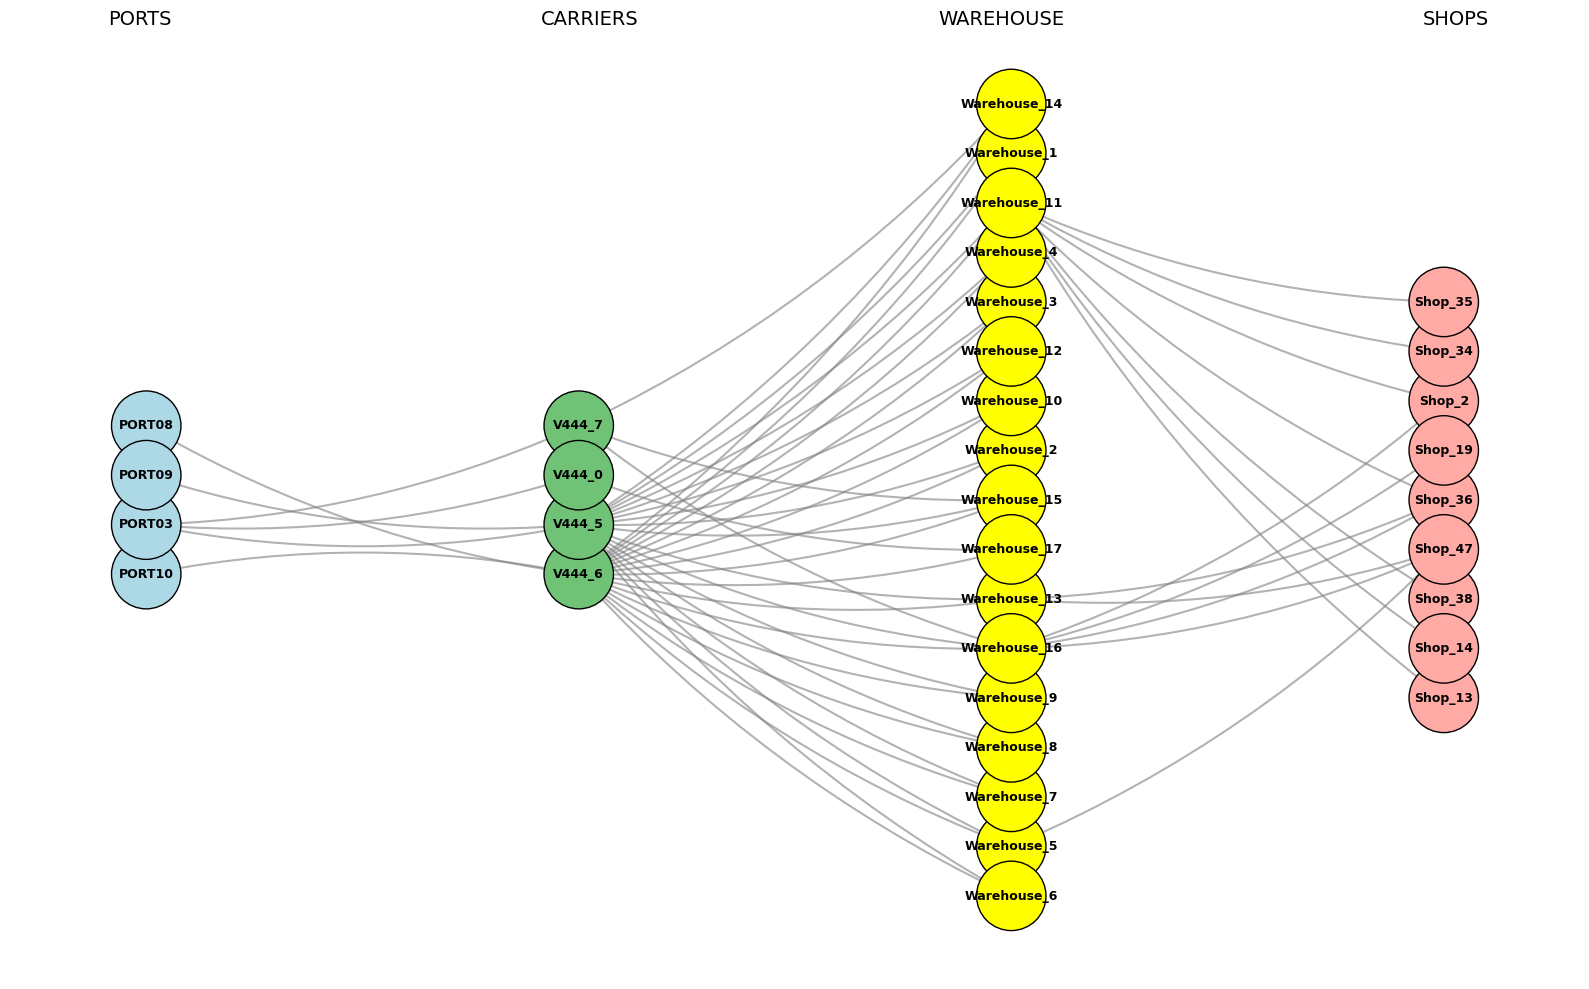

In [13]:
# New data visualisation
G = nx.Graph()

layer_map = {
    'Port': 0,
    'Carrier': 1,
    'Warehouse': 2,
    'Shop': 3,
}

# Helper to add nodes with the correct 'layer' attribute
def add_layered_node(graph, node_name, category):
    if node_name not in graph:
        graph.add_node(node_name, layer=layer_map[category], category=category)

# A. Connect Ports (Layer 0) to Carrier (Layer 1)
for _, row in df_freight.iterrows():
    port = row['orig_port_cd']
    carrier = row['Carrier']

    add_layered_node(G, port, 'Port')
    add_layered_node(G, carrier, 'Carrier')
    G.add_edge(port, carrier)

# B. Connect Carrier (Layer 1) to Warehouse (Layer 2)
for _, row in df_freight.iterrows():
    carrier = row['Carrier']
    warehouse = row['warehouse_id']

    add_layered_node(G, carrier, 'Carrier')
    add_layered_node(G, warehouse, 'Warehouse')
    G.add_edge(carrier, warehouse)

# C. Connect Warehouse (Layer 2) to Shops (Layer 3)
for _, row in df_vmi_shop.iterrows():
    shop = row['Shop']
    warehouse = row['warehouse_id']

    add_layered_node(G, shop, 'Shop')
    add_layered_node(G, warehouse, 'Warehouse')

    G.add_edge(warehouse, shop)

# 3. VISUALIZE WITH MULTIPARTITE LAYOUT
plt.figure(figsize=(16, 10))

# It looks at the 'layer' attribute we set earlier to align nodes vertically
pos = nx.multipartite_layout(G, subset_key="layer")

# Define distinct colors
color_map = []
node_colors = {
    'Port': '#ADD8E6',
    'Carrier': '#6FC276',
    'Warehouse': '#FFFF00',
    'Shop': '#ffaaa5',
    'Product': '#CBC3E3',
}

for node in G:
    cat = G.nodes[node]['category']
    color_map.append(node_colors.get(cat, 'grey'))

# Draw Nodes
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=2500, edgecolors='black')

# Draw Labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Draw Edges (Curved lines often look neater in layered graphs)
# connectionstyle="arc3,rad=0.1" creates a slight curve
nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.6,
                       connectionstyle="arc3,rad=0.1", arrows=True)

# Add Layer Headers (Manual Text to label the columns)
plt.text(-0.25, 1.2, "PORTS", fontsize=14)
plt.text(-0.125, 1.2, "CARRIERS", fontsize=14)
plt.text(-0.01, 1.2, "WAREHOUSE", fontsize=14)
plt.text(0.13, 1.2, "SHOPS", fontsize=14)

plt.axis('off')
plt.tight_layout()
plt.show()

Now, we have the cleansed data. Let's think about optimising this. Since its better to directly find

#### 2.3 Key Entities and Sets
The following players will be considered as the sets for our optimisation problem:
- Plants ($i \in I$): Two plants.
  - Characteristics: Production capacity, unit production cost, defect rate.
  - ShoeCo: Low cost, High defect rate.
  - BootCo: High cost, Low defect rate.
- Ports ($p \in P$): Intermediate transit hubs.
  - Characteristics: Handling capacity, throughput cost.
- Carriers ($k \in K$): Transport options from Ports to Warehouses.     
  - Characteristics: Shipping cost, delivery speed (Fast vs. Slow)
- Warehouses ($w \in W$): Storage facilities.
  - Characteristics: Storage capacity, holding cost, safety regulation (zero tolerance for defective goods storage).
- Shops ($s \in S$): Final retail destinations.
  - Characteristics: Uncertain customer demand.
  - Scenarios ($\omega \in \Omega$): Possible states of the world (e.g., Demand High, Medium, Low) with probability $\pi_\omega$




## 3. The Solution (30%)


#### 3.1 Variables  
**First-Stage Variables (Here-and-Now)**:
- $x_{i}$: Quantity produced at plant $i$.
- $y_{ip}$: Quantity shipped from plant $i$ to port $p$.
- $z_{pwk} \in \{0, 1\}$ (or Integer): Selection of carrier $k$ to transport goods from port $p$ to warehouse $w$.

**Second-Stage Variables (Recourse - Scenario Dependent)**:
- $f_{p w k, \omega}$: Quantity of good product shipped from port $p$ to warehouse $w$ via carrier $k$ in scenario $\omega$.
- $d_{w, \omega}$: Quantity of defective product identified and disposed of/returned at warehouse $w$.
- $I_{w, \omega}$: Inventory level of good product at warehouse $w$ in scenario $\omega$.
- $v_{ws, \omega}$: Quantity shipped from warehouse $w$ to shop $s$ in scenario $\omega$.
- $L_{s, \omega}$: Lost sales (unmet demand) at shop $s$ in scenario $\omega$.

#### 3.2 Parameters and Costs
- Production: $C^{prod}_i$ (Cost), $R^{defect}_i$ (Defect Rate), $Cap^{plant}_i$ (Capacity).
- Logistics:  $C^{carrier}_{pwk}$ (Port-Warehouse),  $C^\text{adv_carrier}_{pwk,\omega}$(Adverse Climate Charge).
- Speed/Market: $\alpha_k$ (Market share bonus factor for fast carriers).
- Inventory: $C^{hold}_w$ (Holding cost per unit), $Req^{safe}_w = 1.4$ (Safety stock ratio: 140% of demand).
- Market: $P^{sell}$ (Selling Price), $D_{s, \omega}$ (Demand at shop $s$ in scenario $\omega$). In our case, we will be looking at a product that is sold for a price of **\$150** by both plants.
- Penalties: $C^{short}$ (Cost per unit of unmet demand) is considered as **\$5** per unit.


#### 3.3 Constraints
**Stage 1 Constraints**:
  1. Production Capacity: $x_i \le Cap^{plant}_i$.
  2. Plant Outflow: $\sum_p y_{ip} = x_i$.

**Stage 2 Constraints** (for each scenario $\omega$):

  3.  Defect Sorting (Entry to Warehouse):
The flow arriving at warehouses must be stripped of defects.

$$\text{Total Volume from } i = y_{ip}$$

$$\text{Good volume} = y_{ip} (1 - R^{defect}_i)$$

$$\sum_{w,k} f_{p w k, \omega} \le \sum_i y_{ip} (1 - R^{defect}_i)$$


4.  Warehouse Balance:
Inflow from ports = Outflow to shops + Inventory.
$$\sum_{p,k} f_{p w k, \omega} = \sum_s v_{ws, \omega} + I_{w, \omega}$$
5.  Safety Stock Regulation:
Warehouse inventory must cover 140% of the goods sent to connected shops.
$$I_{w, \omega} \ge 1.40 \sum_s v_{ws, \omega}$$
<!-- (Note: This is a strict constraint that might force higher production or limit sales). -->
6.  Demand Satisfaction:
$v_{ws, \omega} \le D_{s, \omega}$.
Total Sales at $s$: $\sum_w v_{ws, \omega} + L_{s, \omega} = D_{s, \omega}$.
7.  Defect Handling: Defective items ($x_i \cdot R^{defect}_i$) incur a disposal/handling cost but cannot enter warehouse inventory.

#### 3.4 Objective Function

Maximize:$$\sum_{\omega \in \Omega} \pi_\omega \left[ \text{Revenue}_\omega - (\text{Stage 2 Costs}_\omega) \right] - (\text{Stage 1 Costs})$$
- Stage 1 Costs: Production + Initial Transport + Carrier Selection Fixed Costs.
- Stage 2 Costs: Warehouse-to-Shop Transport + Inventory Holding + Shortage Penalties + Defect Disposal.
- Revenue: $P^{sell} \times (\text{Total Sold}) \times \text{Speed Factor}$. A bonus revenue of **1.1** is multiplied for "Fast" carrier usage for modeling the early market entry advantage.


Now, we understand the way in which we need to optimise this problem. Before using the actual data, we can start with a simple data that is somewhat realistic to see if our approach is working or not.

In [36]:
df_wh_cost["WH"].dropna().unique()

array(['Warehouse_9', 'Warehouse_12', 'Warehouse_11', 'Warehouse_14',
       'Warehouse_13', 'Warehouse_16', 'Warehouse_15', 'Warehouse_1',
       'Warehouse_17', 'Warehouse_6', 'Warehouse_5', 'Warehouse_4',
       'Warehouse_2', 'Warehouse_7', 'Warehouse_8', 'Warehouse_3',
       'Warehouse_10'], dtype=object)

In [37]:
gp.set_options({'USE_PY_VAR_NAME': 'yes'})
m = gp.Container()

# Predefined parameters
dem_data = []
base_dem = {"Shop_1": 100, "Shop_2": 150, "Shop_3": 200, "Shop_4": 120}
factors = {"Low": 0.7, "Medium": 1.0, "High": 1.3}

# Scenario ( ω )	Probability ( πω )	Demand ( Dsω )
# Low Demand	30%	0.7 Dsω
# Medium Demand	50%	 Dsω
# High Demand	20%	1.3 Dsω

# 1. SETS
# Physical Locations
i = gp.Set(m, records=["ShoeCo", "BootCo"], description="Plants")
p = gp.Set(m, records=["Port01", "Port02", "Port03"], description="Ports")
w = gp.Set(m, records=["Warehouse_1", "Warehouse_2", "Warehouse_3"], description="Warehouses")
s = gp.Set(m, records=["Shop_1", "Shop_2", "Shop_3", "Shop_4"], description="Shops")

# Options
k = gp.Set(m, records=["AIR", "GROUND"], description="Carrier Types")

# Stochasticity
omega = gp.Set(m, records=["Low", "Medium", "High"], description="Demand Scenarios")

# 2. PARAMETERS

# --- Plant Data ---
# ShoeCo: Low Cost, High Defect. BootCo: High Cost, Low Defect
# We decide
prod_cost = gp.Parameter(m, domain=[i], records=pd.DataFrame([
    ["ShoeCo", 10.0], ["BootCo", 15.0]], columns=["i", "value"]))

# We decide
defect_rate = gp.Parameter(m, domain=[i], records=pd.DataFrame([
    ["ShoeCo", 0.10], ["BootCo", 0.02]], columns=["i", "value"]))

# We decide
capacity = gp.Parameter(m, domain=[i], records=pd.DataFrame([
    ["ShoeCo", 5000], ["BootCo", 4000]], columns=["i", "value"]))

# --- Logistics Costs ---
# We decide
trans_cost_ip = gp.Parameter(m, domain=[i, p], records=[("ShoeCo","Port01",2.0)]) # Simplified uniform cost

# Carrier Costs (Fast is more expensive)
# df_frieght[]
carrier_cost = gp.Parameter(m, domain=[p, w, k], records=[
    ("Port01", "Warehouse_1", "AIR", 12.0),
    ("Port02", "Warehouse_1", "GROUND", 6.0),
    ("Port03", "Warehouse_1", "AIR", 14.0),
    ("Port01", "Warehouse_2", "GROUND", 8.0),
    ("Port02", "Warehouse_2", "AIR", 11.0),
    ("Port03", "Warehouse_2", "GROUND", 7.0)
])
# Fallback scalar load for example if specific records missing
# In practice, load full dataframe

# Fixed cost for selecting a carrier route (Stage 1 decision cost)
carrier_fixed_cost = gp.Parameter(m, records=1000.0)

# df_vmi_shop[wh_to_shop_cost]
final_dist_cost = gp.Parameter(m, domain=[w, s], records=[
    ("Warehouse_1", "Shop_1", 1.5)
    ])

# --- Scenario Data ---
prob = gp.Parameter(m, domain=[omega], records=pd.DataFrame([
    ["Low", 0.3], ["Medium", 0.5], ["High", 0.2]], columns=["omega", "value"]))

# Demand (scenario dependent)
demand = gp.Parameter(m, domain=[s, omega])
# Generate some dummy demand data
for sh, sc in itertools.product(s.records.uni.values.tolist(), omega.records.uni.values.tolist()):
    dem_data.append([sh, sc, base_dem[sh] * factors[sc]])
demand.setRecords(pd.DataFrame(dem_data, columns=["s", "omega", "value"]))

# --- Economic Parameters ---
price = gp.Parameter(m, records=50.0)
holding_cost = gp.Parameter(m, domain=[w], records=[("Warehouse_1", 0.5)])
shortage_penalty = gp.Parameter(m, records=60.0) # High penalty for lost sales
defect_penalty = gp.Parameter(m, records=5.0) # Cost to dispose

# Market Share / Speed Bonus (Optional revenue booster for using Fast carrier)
# Let's say Fast carrier adds a small premium to revenue or reduces lost sales
# Modeled here as simply a cost trade-off, but could be added to obj.

# 3. VARIABLES

# --- Stage 1 (Here-and-Now) ---
x_prod = gp.Variable(m, domain=[i], type="Positive", description="Production Qty")
y_ship = gp.Variable(m, domain=[i, p], type="Positive", description="Plant to Port Flow")

# Binary decision: Do we contract carrier k for route p->w?
z_select = gp.Variable(m, domain=[p, w, k], type="Binary", description="Carrier Selection")

# --- Stage 2 (Recourse) ---
# Flow of GOOD product
f_flow = gp.Variable(m, domain=[p, w, k, omega], type="Positive", description="Port to WH Flow")

# Inventory at Warehouse
inv = gp.Variable(m, domain=[w, omega], type="Positive", description="Ending Inventory")

# Flow to Shops
v_sales = gp.Variable(m, domain=[w, s, omega], type="Positive", description="WH to Shop Flow")

# Unmet Demand
l_lost = gp.Variable(m, domain=[s, omega], type="Positive", description="Lost Sales")

# Total Profit Variable
profit = gp.Variable(m, type="Free")

# 4. EQUATIONS

# --- Stage 1 Constraints ---

# 1. Production Capacity
eq_cap = gp.Equation(m, domain=[i])
eq_cap[i] = x_prod[i] <= capacity[i]

# 2. Plant Balance (Production = Outflow to Ports)
eq_plant_bal = gp.Equation(m, domain=[i])
eq_plant_bal[i] = x_prod[i] == gp.Sum(p, y_ship[i, p])

# --- Stage 2 Constraints (Scenario Dependent) ---

# 3. Defect Sorting / Port Balance (Linking Stage 1 to Stage 2)
# The sum of flow leaving ports to WHs cannot exceed Good Product arrived at ports.
# Note: We need to sum over plants to get total arrival at port p.
# Total Good Arrival at p = Sum(i, y_ship[i,p] * (1 - defect_rate[i]))
eq_port_bal = gp.Equation(m, domain=[p, omega])

eq_port_bal[p, omega] = (
    gp.Sum([w, k], f_flow[p, w, k, omega]) <=
    gp.Sum(i, y_ship[i, p] * (1 - defect_rate[i]))
)

# 4. Carrier Selection Logical Constraint
# Flow f_flow can only exist if carrier is selected in Stage 1
# Big-M constraint. M can be Total Capacity.
M = 10000
eq_carrier_logic = gp.Equation(m, domain=[p, w, k, omega])
eq_carrier_logic[p, w, k, omega] = f_flow[p, w, k, omega] <= M * z_select[p, w, k]

# 5. Warehouse Balance
# Inflow from Ports = Outflow to Shops + Inventory
eq_wh_bal = gp.Equation(m, domain=[w, omega])
eq_wh_bal[w, omega] = (
    gp.Sum([p, k], f_flow[p, w, k, omega]) ==
    gp.Sum(s, v_sales[w, s, omega]) + inv[w, omega]
)

# 6. Safety Regulation (The 140% Rule)
# Inventory must be >= 1.4 * Total Sales supported by this warehouse
# Wait, problem says "140% of good products available in that shop".
# Interpretation: 140% of what is sent to the shop? Or 140% of demand?
# Let's use: Inventory at W >= 1.4 * (Flow from W to all S)
eq_safety = gp.Equation(m, domain=[w, omega])
eq_safety[w, omega] = inv[w, omega] >= 1.4 * gp.Sum(s, v_sales[w, s, omega])

# 7. Demand Satisfaction
# Sales + Lost = Demand
eq_demand = gp.Equation(m, domain=[s, omega])
eq_demand[s, omega] = gp.Sum(w, v_sales[w, s, omega]) + l_lost[s, omega] == demand[s, omega]

# --- Objective Function ---

# Costs
# Stage 1 Cost: Production + Transport to Port + Carrier Fixed Costs
stage1_cost = (
    gp.Sum(i, prod_cost[i] * x_prod[i]) +
    gp.Sum([i, p], trans_cost_ip[i, p] * y_ship[i, p]) +
    gp.Sum([p, w, k], carrier_fixed_cost * z_select[p, w, k])
)

# Stage 2 Expected Revenue and Costs
# Revenue = Price * Sold (Note: Sold = Demand - Lost)
# Costs = Carrier Transport + WH to Shop Transport + Holding + Shortage + Defect Penalty

# Helper for Defect Cost: Total Produced * Rate * Penalty
defect_cost_total = gp.Sum(i, x_prod[i] * defect_rate[i] * defect_penalty)

# Note on Carrier Cost: Ideally this should be parameter carrier_cost[p,w,k].
# I used scalar 3.0/6.0 in setRecords earlier, assuming parameter exists.

stage2_expected_profit = gp.Sum(omega, prob[omega] * (
    # Revenue
    (price * gp.Sum(s, (demand[s, omega] - l_lost[s, omega]))) -
    # Variable Transport Costs
    (gp.Sum([p, w, k], carrier_cost[p, w, k] * f_flow[p, w, k, omega]) +
      gp.Sum([w, s], final_dist_cost[w, s] * v_sales[w, s, omega])) -
    # Holding Costs
    gp.Sum(w, holding_cost[w] * inv[w, omega]) -
    # Shortage Penalty
    gp.Sum(s, shortage_penalty * l_lost[s, omega])
))

eq_obj = gp.Equation(m)
eq_obj[...] = profit == stage2_expected_profit - stage1_cost - defect_cost_total


# 5. SOLVE
optimal_path_model = gp.Model(
    m,
    equations=m.getEquations(),
    problem="MIP",
    sense="MAX",
    objective=profit
)

optimal_path_model.solve()

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,6923.0,98,138,MIP,CPLEX,0.009


In [66]:
inv.records

,w,omega,level,marginal,lower,upper,scale
0,Warehouse_1,Low,0.0,-0.15,0.0,inf,1.0
1,Warehouse_1,Medium,0.0,-6.25,0.0,inf,1.0
2,Warehouse_1,High,0.0,-22.10,0.0,inf,1.0
3,Warehouse_2,Low,0.0,-0.00,0.0,inf,1.0
4,Warehouse_2,Medium,0.0,-6.00,0.0,inf,1.0
5,Warehouse_2,High,0.0,-22.00,0.0,inf,1.0
6,Warehouse_3,Low,558.6,0.00,0.0,inf,1.0
7,Warehouse_3,Medium,798.0,0.00,0.0,inf,1.0
8,Warehouse_3,High,798.0,0.00,0.0,inf,1.0


Now, lets try putting in the original data that we cleansed and tweaked according to our scenario.

In [56]:
base_dem[sh] * factors[sc]

156.0

In [57]:
from typing import List

# Predefined parameters
demand_multipliers = [50, 100, 20, 10]
base_demand = {demand: int((i+1)*np.random.choice(demand_multipliers))
               for i, demand in enumerate(df_vmi_shop["Shop"])}
factors = {"Low": 0.7, "Medium": 1.0, "High": 1.3}
transport_cost_multiplier = {"AIR": 5, "GROUND": 1} # Price multiplier for modes of transport



def get_optimised_profit(shoeco_production_cost: int, bootco_production_cost: int,
                         shoeco_defective_rate: float, bootco_defective_rate: float,
                         shoeco_production_capacity: int, bootco_production_capacity: int,
                         plant_to_port_cost:List[tuple]):

  dem_data = []

  # Formulating sets from dataframes
  ports = df_plant_ports["Port"].unique().tolist()
  warehouses = df_wh_cost["WH"].dropna().unique().tolist()
  shops = df_vmi_shop["Shop"].unique().tolist()
  carrier_types = df_freight["mode_dsc"].unique().tolist()

  m = gp.Container()

  # SETS
  i = gp.Set(m, records=["ShoeCo", "BootCo"], description="Plants")
  p = gp.Set(m, records=ports, description="Ports")
  w = gp.Set(m, records=warehouses, description="Warehouses")
  s = gp.Set(m, records=shops, description="Shops")
  k = gp.Set(m, records=carrier_types, description="Carrier Types")

  # Stochasticity
  omega = gp.Set(m, records=["Low", "Medium", "High"], description="Demand Scenarios")

  # Production Costs
  prod_cost = gp.Parameter(m, domain=[i], records=pd.DataFrame([
      ["ShoeCo", shoeco_production_cost],
      ["BootCo", bootco_production_cost]], columns=["i", "value"]))

  defect_rate = gp.Parameter(m, domain=[i], records=pd.DataFrame([
      ["ShoeCo", shoeco_defective_rate],
      ["BootCo", bootco_defective_rate]], columns=["i", "value"]))

  capacity = gp.Parameter(m, domain=[i], records=pd.DataFrame([
      ["ShoeCo", shoeco_production_capacity],
      ["BootCo", bootco_production_capacity]], columns=["i", "value"]))

  # Logistics Costs
  trans_cost_ip = gp.Parameter(m, domain=[i, p], records=plant_to_port_cost)

  # Carrier Costs (Fast is more expensive)
  df_freight["total_cost"] = (
    df_freight["minimum cost"]
    * df_freight["rate"]
    * df_freight["mode_dsc"].map(transport_cost_multiplier).fillna(1)
  )

  carrier_cost_df = df_freight[[
      "dest_port_cd",
      "warehouse_id",
      "mode_dsc",
      "total_cost"
  ]]
  carrier_cost = gp.Parameter(m, domain=[p, w, k], records=carrier_cost_df)

  # Fixed cost for selecting a carrier route (Stage 1 decision cost)
  carrier_fixed_cost = gp.Parameter(m, records=1000.0)

  final_dist_cost = gp.Parameter(m, domain=[w, s],
                                 records=df_vmi_shop[["warehouse_id", "Shop",
                                                      "wh_to_shop_cost"]])
  # Scenario Data
  prob = gp.Parameter(m, domain=[omega], records=pd.DataFrame([
      ["Low", 0.3], ["Medium", 0.5], ["High", 0.2]], columns=["omega", "value"]))

  # Demand (scenario dependent)
  demand = gp.Parameter(m, domain=[s, omega])
  for sh, sc in itertools.product(s.records.uni.values.tolist(), omega.records.uni.values.tolist()):
      dem_data.append([sh, sc, base_demand[sh] * factors[sc]])
  demand.setRecords(pd.DataFrame(dem_data, columns=["s", "omega", "value"]))

  # Economic Parameters
  price = gp.Parameter(m, records=50.0)
  holding_cost = gp.Parameter(m, domain=[w], records=[("Warehouse_1", 0.5)])
  shortage_penalty = gp.Parameter(m, records=60.0) # High penalty for lost sales
  defect_penalty = gp.Parameter(m, records=5.0) # Cost to dispose


In [58]:
get_optimised_profit(shoeco_production_cost=15,
                     bootco_production_cost=10,
                     shoeco_defective_rate=0.05,
                     bootco_defective_rate=0.2,
                     shoeco_production_capacity=1000,
                     bootco_production_capacity=5000,
                     plant_to_port_cost=[("ShoeCo","Port01",2.0), ("BootCo", "Port01", 3),
                      ("ShoeCo", "Port02", 4), ("BootCo", "Port02", 4) ]
)

Shop_38 Low
Shop_38 Medium
Shop_38 High
Shop_2 Low
Shop_2 Medium
Shop_2 High
Shop_13 Low
Shop_13 Medium
Shop_13 High
Shop_34 Low
Shop_34 Medium
Shop_34 High
Shop_35 Low
Shop_35 Medium
Shop_35 High
Shop_36 Low
Shop_36 Medium
Shop_36 High
Shop_14 Low
Shop_14 Medium
Shop_14 High
Shop_47 Low
Shop_47 Medium
Shop_47 High
Shop_19 Low
Shop_19 Medium
Shop_19 High


In [ ]:
# df_orderlist = df['OrderList']
# df_freight = df['FreightRates']
# df_wh_cost = df['WhCosts']
# df_wh_capacity = df['WhCapacities']
# df_prod_wh = df['ProductsPerPlant']
# df_wh_ports = df['PlantPorts']
# df_vmi_shop = df['VmiCustomers']

In [ ]:
# Sensitivity Analysis, Visualization (10%)

## Conclusion of the Project

## Extensions of the project
